In [15]:
%matplotlib inline

In [8]:
import matplotlib.pylab as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import sys

In [12]:
# 差分操作,d代表差分序列，比如[1,1,1]可以代表3阶差分。  [12,1]可以代表第一次差分偏移量是12，第二次差分偏移量是1
def diff_ts(ts, d):
    global shift_ts_list
    #  动态预测第二日的值时所需要的差分序列
    global last_data_shift_list #这个序列在恢复过程中需要用到
    shift_ts_list = []
    last_data_shift_list = []
    tmp_ts = ts
    for i in d:
        last_data_shift_list.append(tmp_ts[-i])
        print (last_data_shift_list)
        shift_ts = tmp_ts.shift(i)
        shift_ts_list.append(shift_ts)
        tmp_ts = tmp_ts - shift_ts
    tmp_ts.dropna(inplace=True)
    return tmp_ts

def predict_diff_recover(predict_value, d):
    if isinstance(predict_value, float):
        tmp_data = predict_value
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    elif isinstance(predict_value, np.ndarray):
        tmp_data = predict_value[0]
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    else:
        tmp_data = predict_value
        for i in range(len(d)):
            try:
                tmp_data = tmp_data.add(shift_ts_list[-i-1])
            except:
                raise ValueError('What you input is not pd.Series type!')
        tmp_data.dropna(inplace=True)
    return tmp_data

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=30)
    rolstd = pd.rolling_std(timeseries, window=30)

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


def proper_model(ts_log_diff, maxLag):
    best_p = 0
    best_q = 0
    best_bic = sys.maxsize
    best_model=None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(ts_log_diff, order=(p, q))
            try:
                results_ARMA = model.fit(disp=-1)
            except:
                continue
            bic = results_ARMA.bic
            print (bic, best_bic)
            if bic < best_bic:
                best_p = p
                best_q = q
                best_bic = bic
                best_model = results_ARMA
    print(best_p,best_q,best_model)

In [1]:
df = pd.read_csv('user_balance_table_all.csv', index_col='user_id', names=['user_id', 'report_date', 'tBalance', 'yBalance', 'total_purchase_amt', 'direct_purchase_amt', 'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt', 'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt', 'share_amt', 'category1', 'category2', 'category3', 'category4'
], parse_dates=[1])

df['report_date'] = pd.to_datetime(df['report_date'], errors='coerce')
df['total_purchase_amt'] = pd.to_numeric(df['total_purchase_amt'], errors='coerce')
df['total_redeem_amt'] = pd.to_numeric(df['total_redeem_amt'], errors='coerce')
df['purchase_bank_amt'] = pd.to_numeric(df['purchase_bank_amt'], errors='coerce')

df = df.groupby('report_date').sum()
ts = df['total_purchase_amt']
ts = ts['2014-04-01':'2014-06-29']

df

NameError: name 'pd' is not defined

AttributeError: 'FigureCanvasAgg' object has no attribute 'show'

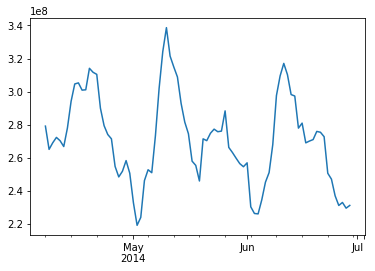

In [16]:
# test_stationarity(ts)

rol_mean = ts.rolling(window=7).mean()
rol_mean.dropna(inplace=True)

rol_mean.plot()
plt.title('Rolling Mean')
plt.show()

ts_diff_1 = diff_ts(rol_mean, [1])

ts_diff_1.plot()
plt.title('First Difference')
plt.show()

# proper_model(ts_diff_1, 10)

plt.figure()
plt.axhline(y=-1.96/np.sqrt(len(ts_diff_1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff_1)),linestyle='--',color='gray')
plot_acf(ts_diff_1, ax=plt.gca(), lags=20)
plt.show()

plt.axhline(y=-1.96/np.sqrt(len(ts_diff_1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff_1)),linestyle='--',color='gray')
plot_pacf(ts_diff_1, ax=plt.gca(), lags=20)

from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff_1, order=(1, 7))
result_arma = model.fit(disp=-1, method='css')

predict_ts = result_arma.predict()

predict_ts.plot(label='predicted')
ts_diff_1.plot(label='original')
plt.legend(loc='best')

recovery_diff_1 = predict_diff_recover(predict_ts, [1])
recovery_diff_1.plot()

rol_sum = ts.rolling(window=6).sum()
rol_recover = recovery_diff_1*7 - rol_sum.shift(1)

rol_recover.plot(label='predicted')
ts.plot(label='original')
plt.legend(loc='best')


In [29]:
a = 5

In [30]:
print(a)

5
